In [1]:
# A Tube Convolutional Neural Network (T-CNN) would have been more suitable model here but due to the time constrain went with 3D-convnet(4D)
# FURTHER IMPROVEMENT in given model
# 300 frames are captured consequtively even if total frame on vidio is upto 900
    # need to spread frame capture all across video at equal interval
# video has lot of frames with no human which acts as noise
    # After ploting captured frames it can be seen that blank frames are darker ie overall sum value will be less than that of images with person so we can add if condition to skip those images with value less than thresold
# images resolution is 40x40 here due to memory issue
# 3 convolution layer used here due to processing shortage
    # Would train on Resnet style deep neural net
# optimisation algorithm used here RMSprop
# model starts to overfit as can be seen in graph when 50 epochs are used
    # regularization needed(dropout,Weight penalty L1 and L2,data augmentation as suggested earlier or use less epochs like 12)
# ensemble can be tried here
# Extract features from each frame with a CNN and pass the sequence to an MLP
    # proven methord which can give upto 70% accuracy compared to current 62%
# other commonly used technique is CNN with LSTM

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D

from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras import backend as K
K.set_image_dim_ordering('th')

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing

C:\Users\DL\Anaconda3\envs\dlwin36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\DL\Anaconda3\envs\dlwin36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
img_rows,img_cols,img_depth=40,40,300

In [4]:
training_X=[]           # variable to store entire dataset


In [5]:
!dir


 Volume in drive D is Storage
 Volume Serial Number is 7E7F-64ED

 Directory of D:\DeepL\action recognition

04/22/2018  04:43 AM    <DIR>          .
04/22/2018  04:43 AM    <DIR>          ..
04/21/2018  09:31 PM    <DIR>          .ipynb_checkpoints
04/22/2018  04:43 AM           219,043 Action detection.ipynb
04/21/2018  09:28 PM    <DIR>          jogging
04/21/2018  04:48 PM        88,525,482 jogging-20180421T111733Z-001.zip
04/21/2018  09:28 PM    <DIR>          Walking
04/21/2018  04:48 PM       126,522,479 Walking-20180421T111744Z-001.zip
04/22/2018  04:43 AM             4,401 walk_jog_weights
04/22/2018  04:43 AM        39,421,464 walk_jog_weights.h5
               5 File(s)    254,692,869 bytes
               5 Dir(s)  41,423,953,920 bytes free


In [6]:
Directory_Walk = os.listdir('Walking')

for video_walk in Directory_Walk:
    print( "total frames in ",video_walk,"are")
    video_walk = 'walking/'+video_walk
    frames = []
    cap = cv2.VideoCapture(video_walk)
    frames_total = int(cap.get(7))
    print(frames_total)
    for k in range(300):
        ret, frame = cap.read()
        frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)
    cap.release()
    cv2.destroyAllWindows()
    input=np.array(frames)
    input_swap=np.rollaxis(np.rollaxis(input,2,0),2,0)#reformat input shape for keras compatibility

    training_X.append(input_swap)


total frames in  person01_walking_d1_uncomp.avi are
555
total frames in  person01_walking_d2_uncomp.avi are
675
total frames in  person01_walking_d3_uncomp.avi are
950
total frames in  person01_walking_d4_uncomp.avi are
565
total frames in  person02_walking_d1_uncomp.avi are
450
total frames in  person02_walking_d2_uncomp.avi are
1060
total frames in  person02_walking_d3_uncomp.avi are
542
total frames in  person02_walking_d4_uncomp.avi are
460
total frames in  person03_walking_d1_uncomp.avi are
640
total frames in  person03_walking_d2_uncomp.avi are
960
total frames in  person03_walking_d3_uncomp.avi are
1120
total frames in  person03_walking_d4_uncomp.avi are
432
total frames in  person04_walking_d1_uncomp.avi are
470
total frames in  person04_walking_d2_uncomp.avi are
840
total frames in  person04_walking_d3_uncomp.avi are
480
total frames in  person04_walking_d4_uncomp.avi are
418
total frames in  person05_walking_d1_uncomp.avi are
535
total frames in  person05_walking_d2_uncomp.av

In [7]:
print(training_X)

[array([[[145, 145, 145, ..., 145, 144, 145],
        [149, 149, 148, ..., 145, 145, 145],
        [150, 150, 149, ..., 144, 144, 145],
        ...,
        [145, 145, 145, ..., 147, 147, 146],
        [144, 144, 144, ..., 146, 146, 146],
        [144, 144, 144, ..., 145, 145, 144]],

       [[137, 137, 138, ..., 139, 139, 139],
        [136, 136, 135, ..., 139, 139, 139],
        [136, 136, 135, ..., 138, 138, 138],
        ...,
        [136, 136, 136, ..., 139, 139, 137],
        [133, 133, 133, ..., 140, 140, 140],
        [135, 135, 135, ..., 140, 140, 140]],

       [[136, 136, 136, ..., 135, 135, 135],
        [137, 137, 137, ..., 134, 134, 134],
        [137, 137, 136, ..., 134, 134, 134],
        ...,
        [136, 136, 136, ..., 133, 133, 133],
        [136, 136, 136, ..., 135, 135, 134],
        [137, 137, 137, ..., 133, 133, 134]],

       ...,

       [[118, 118, 117, ..., 118, 118, 118],
        [125, 125, 123, ..., 118, 118, 117],
        [120, 120, 118, ..., 117, 117, 11

In [8]:
#Reading running action class
  
Directory_Jog = os.listdir('jogging')

for video_jog in Directory_Jog:
    print( "total frames in ",video_walk,"are")
    video_jog = 'jogging/'+video_jog
    frames = []
    cap = cv2.VideoCapture(video_jog)
    frames_total = int(cap.get(7))
    print(frames_total)
    
    for k in range(300):
        ret, frame = cap.read()
        frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)
    cap.release()
    cv2.destroyAllWindows()
    input=np.array(frames)
    input_swap=np.rollaxis(np.rollaxis(input,2,0),2,0)#reformat input shape for keras compatibility
    training_X.append(input_swap)

total frames in  walking/person13_walking_d4_uncomp.avi are
415
total frames in  walking/person13_walking_d4_uncomp.avi are
425
total frames in  walking/person13_walking_d4_uncomp.avi are
405
total frames in  walking/person13_walking_d4_uncomp.avi are
362
total frames in  walking/person13_walking_d4_uncomp.avi are
345
total frames in  walking/person13_walking_d4_uncomp.avi are
626
total frames in  walking/person13_walking_d4_uncomp.avi are
350
total frames in  walking/person13_walking_d4_uncomp.avi are
324
total frames in  walking/person13_walking_d4_uncomp.avi are
492
total frames in  walking/person13_walking_d4_uncomp.avi are
620
total frames in  walking/person13_walking_d4_uncomp.avi are
380
total frames in  walking/person13_walking_d4_uncomp.avi are
360
total frames in  walking/person13_walking_d4_uncomp.avi are
335
total frames in  walking/person13_walking_d4_uncomp.avi are
510
total frames in  walking/person13_walking_d4_uncomp.avi are
325
total frames in  walking/person13_walkin

In [9]:
training_X_array = np.array(training_X)   # convert the frames to array
video_count = len(training_X_array) 
print(video_count)

104


In [10]:
print(training_X_array.shape)

(104, 40, 40, 300)


In [11]:
label=np.ones((video_count,),dtype = int)

In [12]:
print(label.shape)

(104,)


In [13]:
#class values
label[0:52]= 0
label[52:104] = 1

In [14]:
print(label[51])

0


In [15]:
train_data = [training_X_array,label]#train and test data into single array

(X_train, y_train) = (train_data[0],train_data[1])# splitting train and test
print('X_Train shape:', X_train.shape)

train_set = np.zeros((video_count, 1, img_rows,img_cols,img_depth))
for h in range(video_count):
    train_set[h][0][:][:][:]=X_train[h,:,:,:]
    
print(train_set.shape, 'train samples')

X_Train shape: (104, 40, 40, 300)
(104, 1, 40, 40, 300) train samples


In [16]:
# CNN Training parameters

batch_size = 2
classes = 2 #total no of class
epoch = 10

In [17]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, classes)

In [18]:
# number of convolutional filters to use at each layer
filters = [32, 32]

In [19]:
# level of pooling to perform at each layer (POOL x POOL)
pool = [3, 3]

In [20]:
conv = [5,5]

In [21]:
# Pre-processing

train_set = train_set.astype('float32')

train_set -= np.mean(train_set)

train_set /= np.max(train_set)

In [22]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

In [23]:
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
# Define model

model = Sequential()

    #1ST layer group
model.add(Convolution3D(filters[0], kernel_dim1=conv[0], kernel_dim2=conv[0], kernel_dim3=conv[0],input_shape=(1, img_rows, img_cols, img_depth), activation='relu'))
model.add(MaxPooling3D(pool_size=(pool[0], pool[0], pool[0])))

model.add(Dropout(0.5))
    # 2nd layer group
model.add(Convolution3D(128, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv2',
                            subsample=(1, 1, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), 
                           border_mode='valid', name='pool2'))
    # 3rd layer group
model.add(Convolution3D(256, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv3a',
                            subsample=(1, 1, 1)))
model.add(Convolution3D(256, 3, 3, 3, activation='relu', 
                            border_mode='same', name='conv3b',
                            subsample=(1, 1, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), 
                           border_mode='valid', name='pool3'))

model.add(Flatten())

model.add(Dense(128, init='normal', activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(classes,init='normal'))

model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

C:\Users\DL\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (5, 5, 5), input_shape=(1, 40, 40..., activation="relu")`
  import sys
C:\Users\DL\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", strides=(1, 1, 1), padding="same")`
  
C:\Users\DL\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool2", padding="valid")`
  app.launch_new_instance()
C:\Users\DL\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(256, (3, 3, 3), activation="relu", name="conv3a", strides=(1, 1, 1), padding="same")`
C:\Users\DL\Anaconda3\envs\dlwin36\lib\site-packages\ipy

In [24]:
# Split the dat
X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(train_set, Y_train, test_size=0.2, random_state=4)

In [25]:
# Train the model

hist = model.fit(X_train_new, y_train_new, validation_data=(X_val_new,y_val_new),batch_size=batch_size,epochs = epoch ,verbose=2)


Train on 83 samples, validate on 21 samples
Epoch 1/50
 - 8s - loss: 0.8395 - acc: 0.5422 - val_loss: 0.7025 - val_acc: 0.3810
Epoch 2/50
 - 6s - loss: 0.6486 - acc: 0.6867 - val_loss: 0.6071 - val_acc: 0.7619
Epoch 3/50
 - 6s - loss: 0.6139 - acc: 0.6867 - val_loss: 0.5887 - val_acc: 0.6190
Epoch 4/50
 - 6s - loss: 0.6344 - acc: 0.7108 - val_loss: 0.7730 - val_acc: 0.6190
Epoch 5/50
 - 6s - loss: 0.6822 - acc: 0.6627 - val_loss: 0.6758 - val_acc: 0.5714
Epoch 6/50
 - 6s - loss: 0.5040 - acc: 0.7349 - val_loss: 0.6184 - val_acc: 0.6667
Epoch 7/50
 - 6s - loss: 0.5502 - acc: 0.7590 - val_loss: 0.7292 - val_acc: 0.3810
Epoch 8/50
 - 6s - loss: 0.4863 - acc: 0.7229 - val_loss: 0.5943 - val_acc: 0.6190
Epoch 9/50
 - 6s - loss: 0.4801 - acc: 0.7229 - val_loss: 0.6239 - val_acc: 0.5714
Epoch 10/50
 - 6s - loss: 0.4264 - acc: 0.7831 - val_loss: 0.6438 - val_acc: 0.4762
Epoch 11/50
 - 6s - loss: 0.4599 - acc: 0.8193 - val_loss: 0.6125 - val_acc: 0.7143
Epoch 12/50
 - 6s - loss: 0.4162 - acc: 0

In [26]:
 # Evaluate the model
score = model.evaluate(X_val_new, y_val_new, batch_size=batch_size, verbose=2)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Test score: 0.6672501714811439
Test accuracy: 0.6666666666666666


['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', '_classic_test']


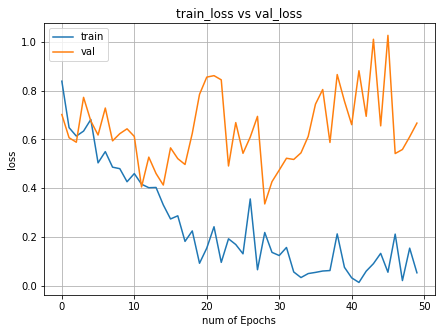

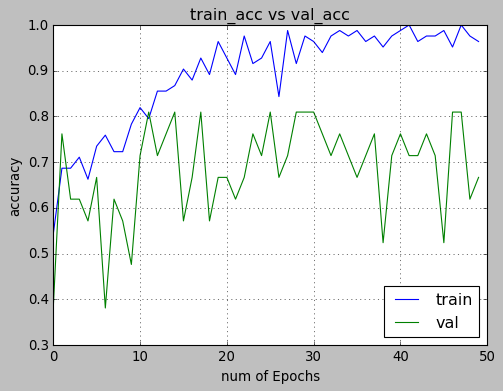

In [27]:
# Plot the results
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print (plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [28]:
import h5py

model.save_weights('walk_jog_weights.h5', overwrite=True)
json_string = model.to_json()
with open('walk_jog_weights', 'w') as f:
    f.write(json_string)